# Motion segmentation

In [1]:
# For Kmeans algorithm. See PGM otherwise for handcrafted class
from sklearn.cluster import KMeans
# For loading matlab matrix file
from scipy.io import loadmat
# Hungarian algorithm
from scipy.optimize import linear_sum_assignment

#from scipy.sparse.linalg import eigs, eigsh
from scipy.stats import itemfreq
import numpy as np

#Progressbar
from tqdm import tqdm

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
%precision %.5f
%load_ext line_profiler

plt.rc('text', usetex=True)
plt.rc('font',**{'family':'serif','serif':['Palatino']})

In [3]:
#Algorithm and error
from error_evaluation import *
from ksubspaces import *
from spectral_clustering import *
from SSC import *

In [76]:
plt.rc('text', usetex=True)
plt.rc('font',**{'family':'serif','serif':['Palatino']})

plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30

Extrait de 

@article{elhamifar2013sparse,

  title={Sparse subspace clustering: Algorithm, theory, and applications},
  
  author={Elhamifar, Ehsan and Vidal, Rene},
  
  journal={IEEE transactions on pattern analysis and machine intelligence},
  
  volume={35},
  
  number={11},
  
  pages={2765--2781},
  
  year={2013},
  
  publisher={IEEE}
  
}


![article](real_data_article.png)

## Globals

In [4]:
DATA_DIR = "data/Hopkins155/"
NEEDLE = "_truth.mat"

## Data

In [5]:
import glob
import os

In [6]:
motion_data = {}
count_files = 0
# iglob for iterator
## Recursive=True to use **
for file in glob.iglob(DATA_DIR + "**/*" + NEEDLE, recursive = True):
    mat_name = file.split("/")[-1].split(NEEDLE)[0]
    try:
        # Load matlab matrix
        motion_data[mat_name] = loadmat(file)
        # Cast in float64 x
        motion_data[mat_name]['x'] = motion_data[mat_name]\
        ['x'].astype(np.float64, subok = True, copy = False)
        # Cast number of points in int
        motion_data[mat_name]['points'] = motion_data[mat_name]\
        ['points'][0, 0].astype(int)
        # Cast number of frames in int
        motion_data[mat_name]['frames'] = motion_data[mat_name]\
        ['frames'][0, 0].astype(int)
        # Substract 1 to matlab labels
        motion_data[mat_name]['s'] -= 1
    except OSError:
        print ('cannonot open ', file)
    else:
        count_files += 1
        motion_data[mat_name]["data"] = \
        np.transpose(motion_data[mat_name]['x'][:2, : :],
                     axes = (0, 2, 1)).reshape(2 * motion_data[mat_name]['frames'],
                                               motion_data[mat_name]["points"])
print ("Number of files loaded : {}".format(count_files))

Number of files loaded : 156


## Results zone : SSC

In [10]:
Res = np.load('motion_res_SSC.npy').item()

### $tau = 1e3$, $mu=1e3$

In [38]:
tau = 1e3
mu = 1e3

In [44]:
Res[(tau, mu)] = {}
for key in tqdm(motion_data.keys()):
    # Number of ground_truth classes
    nbr_classes = motion_data[key]["s"].max() + 1
    Res[(tau, mu)][key] = evaluate_error(SSC(motion_data[key]["data"], nbr_classes, tau, mu)[1],
                              motion_data[key]["s"].reshape(-1))

In [58]:
Res.keys()

dict_keys([(1000.0, 1000.0), (10000.0, 1000.0)])

In [64]:
Res[(1e4, 1e3)]

0.01303

### $tau = 1e4$, $mu=1e3$

In [65]:
tau = 1e4
mu = 1e3
Res[(tau, mu)] = {}
for key in tqdm(motion_data.keys()):
    # Number of ground_truth classes
    nbr_classes = motion_data[key]["s"].max() + 1
    Res[(tau, mu)][key] = evaluate_error(SSC(motion_data[key]["data"], nbr_classes, tau, mu)[1],
                              motion_data[key]["s"].reshape(-1))

100%|██████████| 156/156 [24:43<00:00,  9.51s/it]


### $tau = 1e5$, $mu=1e3$

In [68]:
tau = 1e5
mu = 1e3
Res[(tau, mu)] = {}
for key in tqdm(motion_data.keys()):
    # Number of ground_truth classes
    nbr_classes = motion_data[key]["s"].max() + 1
    Res[(tau, mu)][key] = evaluate_error(SSC(motion_data[key]["data"], nbr_classes, tau, mu)[1],
                              motion_data[key]["s"].reshape(-1))

100%|██████████| 156/156 [23:49<00:00,  9.16s/it]


### $tau = 1e6$, $mu=1e3$

In [82]:
tau = 1e6
mu = 1e3
Res[(tau, mu)] = {}
for key in tqdm(motion_data.keys()):
    # Number of ground_truth classes
    nbr_classes = motion_data[key]["s"].max() + 1
    Res[(tau, mu)][key] = evaluate_error(SSC(motion_data[key]["data"], nbr_classes, tau, mu)[1],
                              motion_data[key]["s"].reshape(-1))

100%|██████████| 156/156 [19:55<00:00,  7.66s/it]


### $tau = 1e7$, $mu=1e3$

In [92]:
tau = 1e7
mu = 1e3
Res[(tau, mu)] = {}
for key in tqdm(motion_data.keys()):
    # Number of ground_truth classes
    nbr_classes = motion_data[key]["s"].max() + 1
    Res[(tau, mu)][key] = evaluate_error(SSC(motion_data[key]["data"], nbr_classes, tau, mu)[1],
                              motion_data[key]["s"].reshape(-1))

100%|██████████| 156/156 [32:19<00:00, 12.43s/it]


In [11]:
#np.save('motion_res_SSC.npy', Res)

## Results zone : K-subspace
Figure 11.4 shows the singular values of the matrix of feature point trajectories
of a single motion for several videos in the data set. Note that the singular value
curve has a knee around 4, corroborating the approximate 4-dimensionality of the
motion data in each video.

In [7]:
#K_sub = {}
K_sub = np.load("motion_res_ksub.npy").item()

In [8]:
K_sub

{1: {'1R2RC': 0.20697,
  '1R2RCR': 0.20539,
  '1R2RCR_g12': 0.00000,
  '1R2RCR_g13': 0.24274,
  '1R2RCR_g23': 0.19907,
  '1R2RCT_A': 0.13302,
  '1R2RCT_A_g12': 0.00000,
  '1R2RCT_A_g13': 0.18456,
  '1R2RCT_A_g23': 0.48000,
  '1R2RCT_B': 0.13082,
  '1R2RCT_B_g12': 0.00000,
  '1R2RCT_B_g13': 0.15337,
  '1R2RCT_B_g23': 0.12532,
  '1R2RC_g12': 0.00000,
  '1R2RC_g13': 0.32544,
  '1R2RC_g23': 0.19459,
  '1R2TCR': 0.13129,
  '1R2TCRT': 0.16700,
  '1R2TCRT_g12': 0.00000,
  '1R2TCRT_g13': 0.21751,
  '1R2TCRT_g23': 0.18605,
  '1R2TCR_g12': 0.00000,
  '1R2TCR_g13': 0.23358,
  '1R2TCR_g23': 0.13071,
  '1RT2RCR': 0.12805,
  '1RT2RCRT': 0.10000,
  '1RT2RCRT_g12': 0.00000,
  '1RT2RCRT_g13': 0.16129,
  '1RT2RCRT_g23': 0.12121,
  '1RT2RCR_g12': 0.00000,
  '1RT2RCR_g13': 0.16667,
  '1RT2RCR_g23': 0.47714,
  '1RT2RTCRT_A': 0.14634,
  '1RT2RTCRT_A_g12': 0.00000,
  '1RT2RTCRT_A_g13': 0.16732,
  '1RT2RTCRT_A_g23': 0.16742,
  '1RT2RTCRT_B': 0.19494,
  '1RT2RTCRT_B_g12': 0.00599,
  '1RT2RTCRT_B_g13': 0.22430,

In [31]:
for restarts in [1, 3, 5, 10, 20, 50, 100, 200, 500]:
    K_sub[restarts] = {}
    for key in tqdm(motion_data.keys()):
        # Number of ground_truth classes
        nbr_classes = motion_data[key]["s"].max() + 1
        K_sub[restarts][key] = evaluate_error(ksubspaces(motion_data[key]["data"], nbr_classes,
                                                         nbr_classes * [4], restarts)[0][0],
                                              motion_data[key]["s"].reshape(-1))
#np.save('motion_res_ksub.npy', K_sub)


 57%|█████▋    | 89/156 [00:30<00:22,  2.96it/s]
Exception in thread Thread-11:
Traceback (most recent call last):
  File "/usr/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.5/dist-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/usr/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

100%|██████████| 156/156 [2:23:14<00:00, 55.09s/it] 


## Spectral clustering 

In [ ]:
SC_res = np.load('motion_res_SC.npy').item()

In [ ]:
for k in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 15, 20, 30, 50]:
    for s in [1e0, 1e1, 1e2, 1e3, 1e4, 1e5]:
        SC_res[(k, s)] = {}
        for key in tqdm(motion_data.keys()):
            W = gaussian_affinity(motion_data[key]["data"], k, s)
            # Number of ground_truth classes
            nbr_classes = motion_data[key]["s"].max() + 1
            SC_res[(k, s)][key] = evaluate_error(SC(W, nbr_classes), motion_data[key]["s"].reshape(-1))
np.save("motion_res_SC.npy", SC_res)

 13%|█▎        | 21/156 [00:01<00:10, 13.45it/s]

In [184]:
SC_res.keys()

dict_keys([(1, 10000.0), (10, 1000.0), (8, 100000.0), (6, 1000.0), (2, 10000.0), (2, 1.0), (8, 10.0), (3, 1000.0), (1, 1000.0), (7, 10000.0), (5, 100000.0), (5, 1.0), (7, 1000.0), (2, 100.0), (9, 1.0), (3, 1.0), (10, 100.0), (4, 1000.0), (8, 1.0), (2, 1000.0), (3, 10.0), (6, 10.0), (6, 100000.0), (3, 100.0), (7, 10.0), (3, 10000.0), (1, 100000.0), (8, 10000.0), (4, 1.0), (1, 1.0), (5, 1000.0), (4, 10.0), (9, 100000.0), (6, 100.0), (7, 100000.0), (7, 1.0), (4, 100.0), (4, 10000.0), (9, 10.0), (2, 100000.0), (9, 10000.0), (8, 1000.0), (10, 1.0), (10, 100000.0), (2, 10.0), (8, 100.0), (7, 100.0), (5, 100.0), (5, 10.0), (5, 10000.0), (10, 10.0), (3, 100000.0), (10, 10000.0), (6, 1.0), (1, 10.0), (1, 100.0), (6, 10000.0), (9, 100.0), (9, 1000.0), (4, 100000.0)])

## Exploitation

In [110]:
SSC_res = np.load('motion_res_SSC.npy').item()
K_sub = np.load("motion_res_ksub.npy").item()
SC_res = np.load('motion_res_SC.npy').item()

### Sequences = f(missclassification)

In [163]:
lines = [(0, ())]
colors = ["black", "red", "lightcoral", "turquoise", "magenta", "olive", "lime", "gray", "gold", "blue"]
from itertools import cycle
linecycler = cycle(lines)

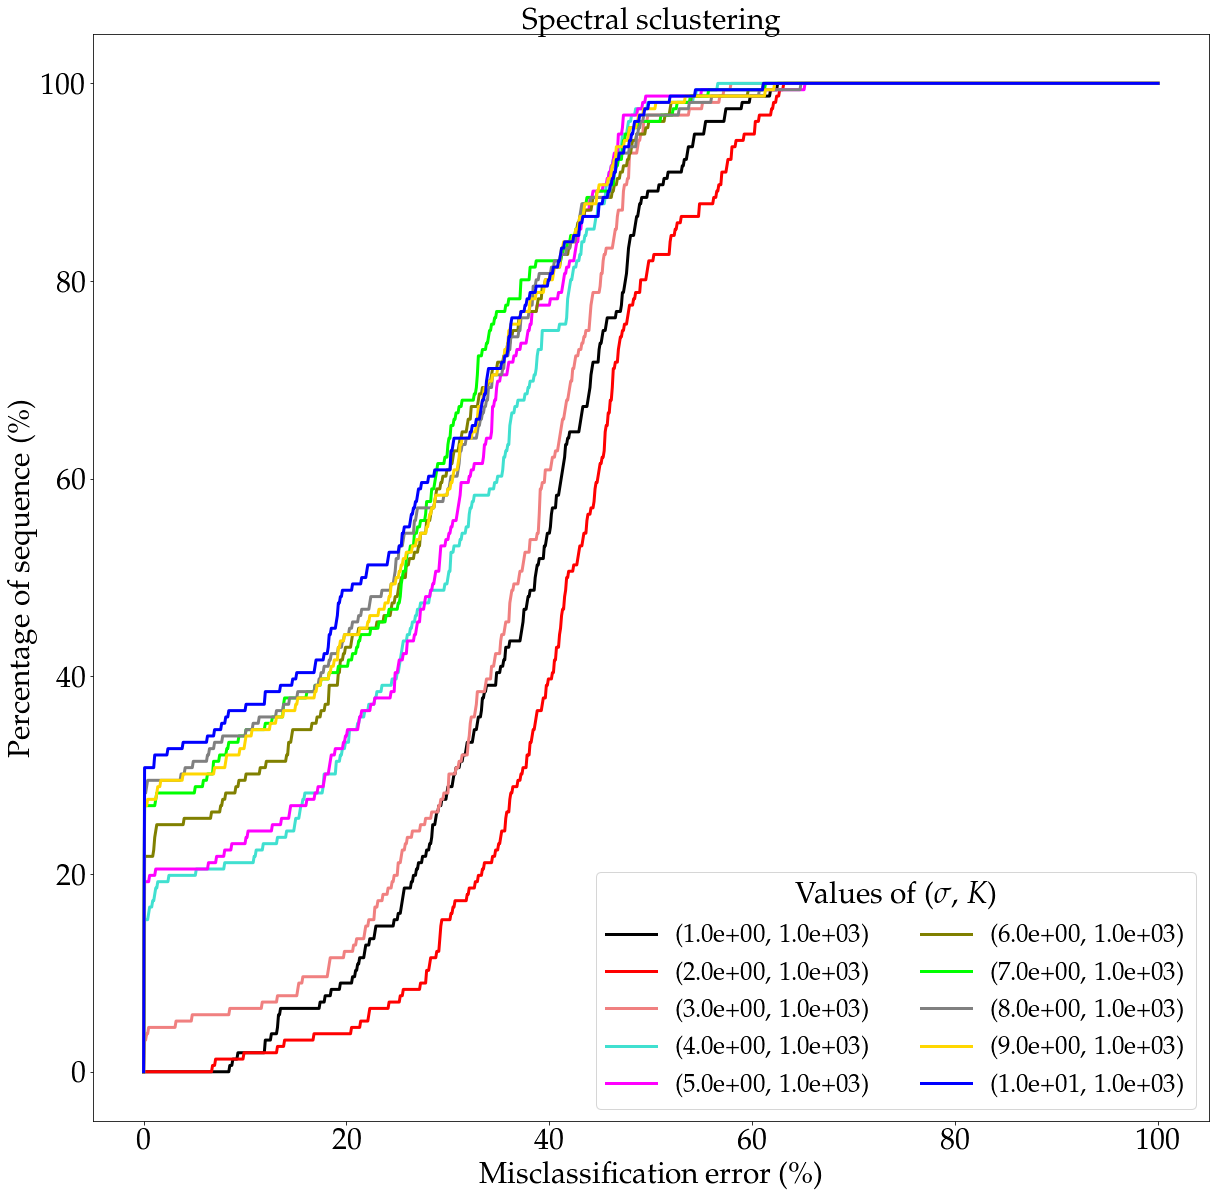

In [182]:
step = 0.001
X = 100 * np.arange(0, 1 + step, step)

plt.figure(figsize = (20, 20))


Params = list(SC_res.keys())
Params.sort()

# for params in Params:
for params in [(i, 1e3) for i in range(1, 11)]:
    Y = [0] * len(X)
    for x in range(len(X)):
        for key in SC_res[params].keys():
            if SC_res[params][key] < X[x] / 100:
                Y[x] += 100/len(SC_res[params])
    plt.plot(X, Y, color = colors[int(params[0]) - 1], lw = 3,
             label = "({:.1e}, {:.1e})".format(params[0], params[1]));
plt.title("Spectral sclustering", size = 30)
plt.ylabel(r"Percentage of sequence (\%)", size = 30)
plt.xlabel(r"Misclassification error (\%)", size = 30)
leg = plt.legend(fontsize = 25, ncol = 2);
leg.set_title(r"Values of ($\sigma$, $K$)" , prop = {'size': 30})
plt.savefig("../report/images/SC_1e3.png")

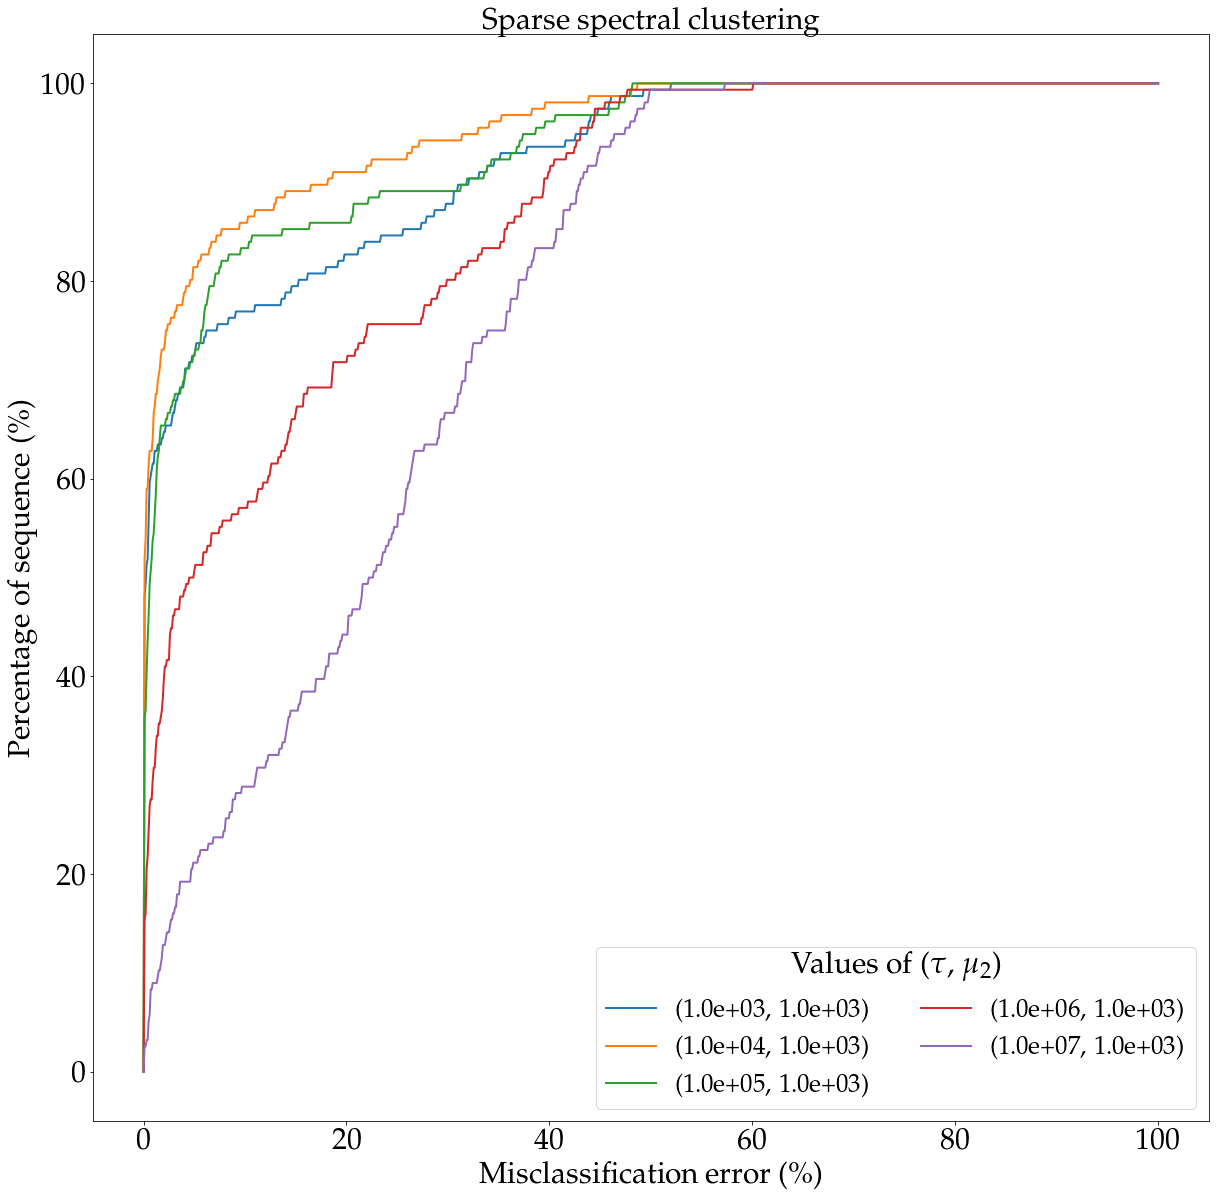

In [183]:
step = 0.001
X = 100 * np.arange(0, 1 + step, step)

plt.figure(figsize = (20, 20))

Params = list(SSC_res.keys())
Params.sort()
for params in Params:
    Y = [0] * len(X)
    for x in range(len(X)):
        for key in SSC_res[params].keys():
            if SSC_res[params][key] < X[x] / 100:
                Y[x] += 100/len(SSC_res[params])
    plt.plot(X, Y, label = "({:.1e}, {:.1e})".format(params[0], params[1]), lw = 2);
plt.title("Sparse spectral clustering", size = 30)
plt.ylabel(r"Percentage of sequence (\%)", size = 30)
plt.xlabel(r"Misclassification error (\%)", size = 30)
leg = plt.legend(fontsize = 25, ncol = 2);
leg.set_title(r"Values of ($\tau$, $\mu_2$)" , prop = {'size': 30})

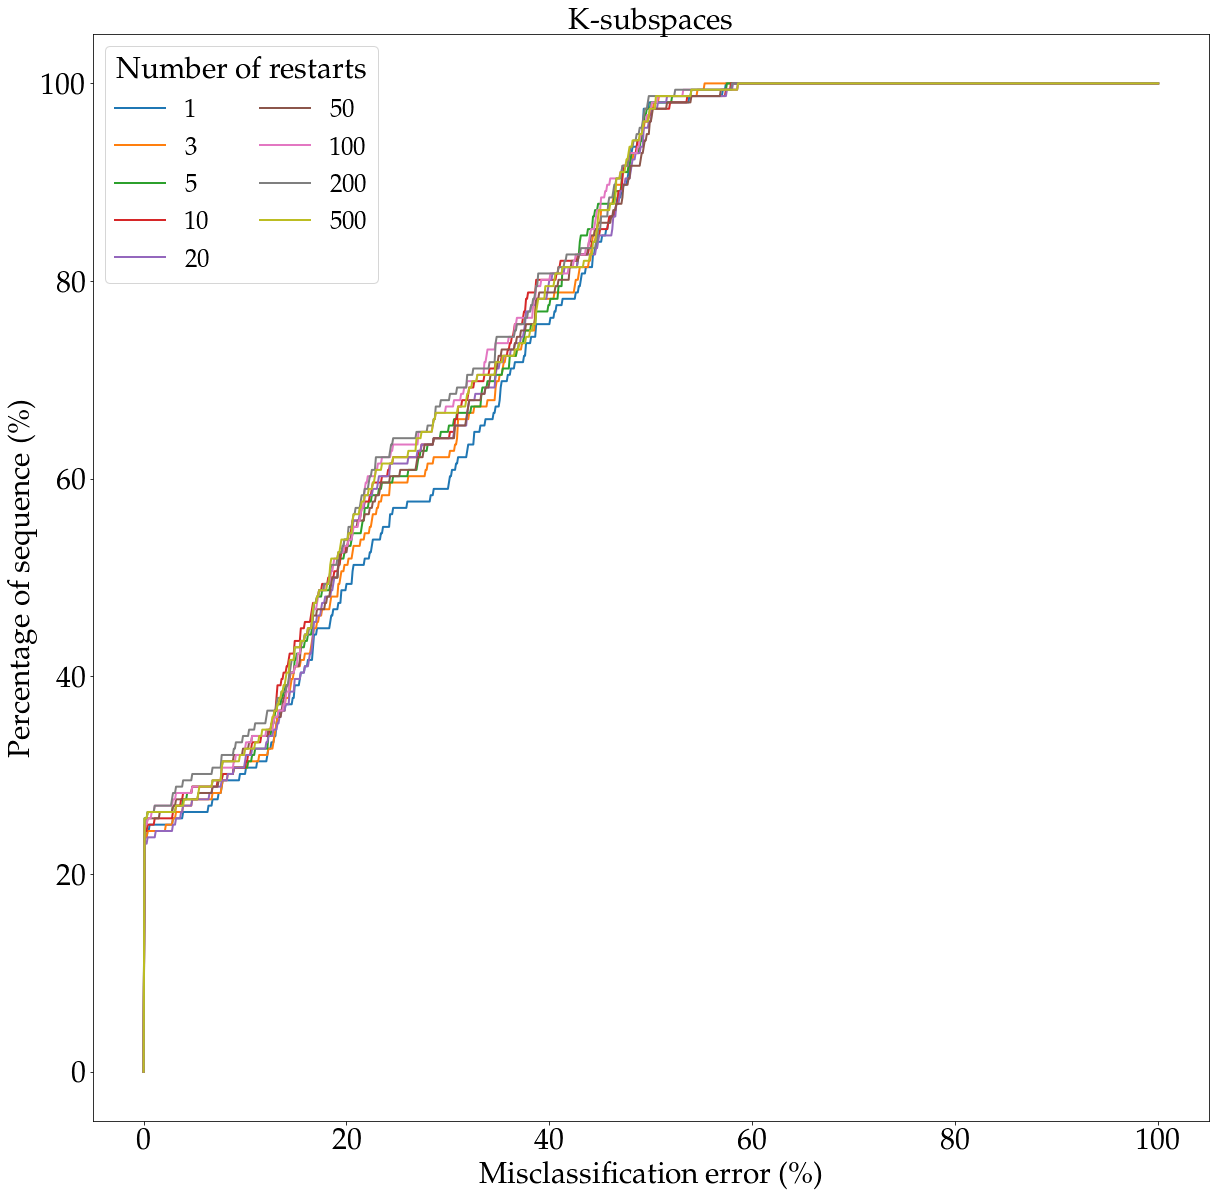

In [116]:
step = 0.001
X = 100 * np.arange(0, 1 + step, step)

plt.figure(figsize = (20, 20))

Params = list(K_sub.keys())
Params.sort()
for params in Params:
    Y = [0] * len(X)
    for x in range(len(X)):
        for key in K_sub[params].keys():
            if K_sub[params][key] < X[x] / 100:
                Y[x] += 100/len(K_sub[params])
    plt.plot(X, Y, label = params, lw = 2);
plt.title("K-subspaces", size = 30)
plt.ylabel(r"Percentage of sequence (\%)", size = 30)
plt.xlabel(r"Misclassification error (\%)", size = 30)
leg = plt.legend(fontsize = 25, ncol = 2);
leg.set_title("Number of restarts" , prop = {'size': 30})

## Mean and median of the algorithms for different parameters for each category of Hopkins 155

In [ ]:
motion_data